# Analisi della pressata n5

Fasi: 
* Import dei dati e visualizzazione andamenti
* Clustering gerarchico per identificare il numero di cluster
* Clustering attraverso K-means
* Clustering via  kernal K-means
* Divisione del dataset in funzione dei cluster per analisi del singolo cluster
* Stima funzione baricentrica del cluster e calcolo degli outlier
* Plot dell'esito sul grafico

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 1 - Import di dati e librerie

In [2]:
local_path = './'
pressate = pd.read_csv(local_path + 'data/pressate.csv')
esiti = pd.read_csv(local_path + 'data/target_all.csv')

In [3]:
# tolgo i rework ed il primo valore di ogni sequenza
pressate = pressate[(pressate['Rework'] == False) & (pressate['Indice'] != 1)]

# trasformo il la colonna data in datetime
pressate['DataInsert'] = pd.to_datetime(pressate['DataInsert'])

# escludo tutti i campioni prodotti nei primi due mesi 
pressate = pressate[pressate['DataInsert']>pd.to_datetime('2021-1-10 11:46:56.147')]

# droppo colonne che non servono  
pressate = pressate.drop(['Unnamed: 0', 'ID', 'Indice',
                         'DataReg', 'Md5ValoriPrecedenti', 'Rework'], axis=1)

**Plot doppio di quota e valore**

Sono contenute tutte le sequenze presenti nel dataset 

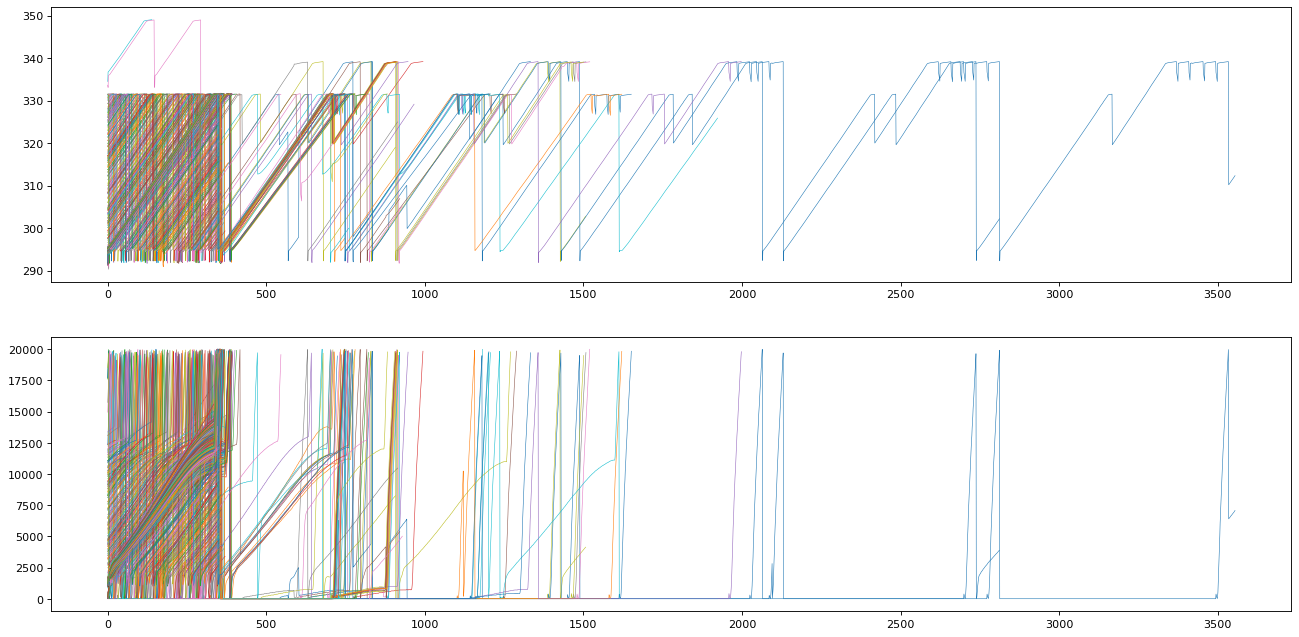

In [8]:
press_by_serial = pressate.groupby(['Seriale'])
# plot
fig, ax = plt.subplots(2,1, figsize=(20, 10), dpi=80)
for key, frame in press_by_serial:

    pressate_group = frame.groupby('Pressata')
    
    for pressata, var in pressate_group:
        
        if len(var['Quota']) < 5000 and pressata==5:
            quota = var['Quota']#[var['Quota']>0]
            valore = var['Valore']

            ax[0].plot(list(range(0,len(quota))),quota, linewidth=0.5)
            ax[1].plot(list(range(0,len(valore))),valore, linewidth=0.5)
plt.show()   

**Plot doppio di quota e valore**

Sono state escluse tutte le sequenze con lunghezza superiore a 1000 

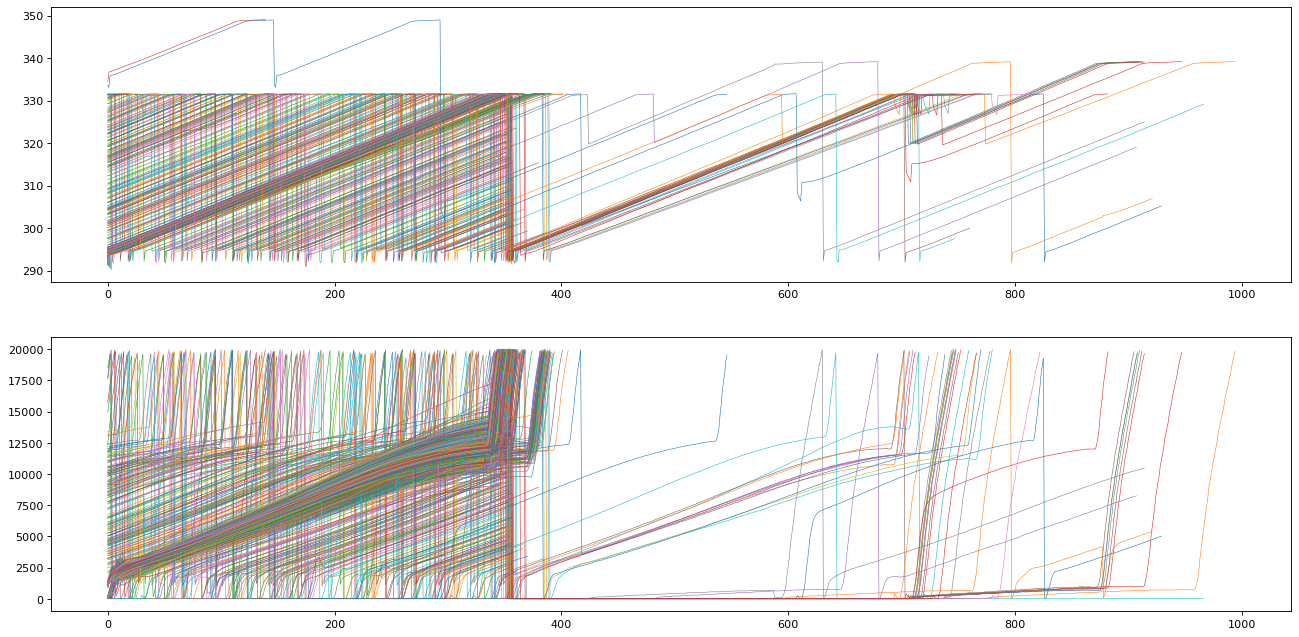

In [9]:
press_by_serial = pressate.groupby(['Seriale'])
# plot
fig, ax = plt.subplots(2,1, figsize=(20, 10), dpi=80)
for key, frame in press_by_serial:

    pressate_group = frame.groupby('Pressata')
    
    for pressata, var in pressate_group:
        
        if len(var['Quota']) < 1000 and pressata==5:
            quota = var['Quota']#[var['Quota']>0]
            valore = var['Valore']

            ax[0].plot(list(range(0,len(quota))),quota, linewidth=0.5)
            ax[1].plot(list(range(0,len(valore))),valore, linewidth=0.5)
plt.show()   

In [10]:
!ls


data		   press_analisi_completa.ipynb  pressate_analisi.py
dtw_cluster.ipynb  pressata5.ipynb		 pressate_CNN.py
plotwtc.py	   pressate_algoritmo.ipynb	 SVC.ipynb


Plot del rapport quota valore

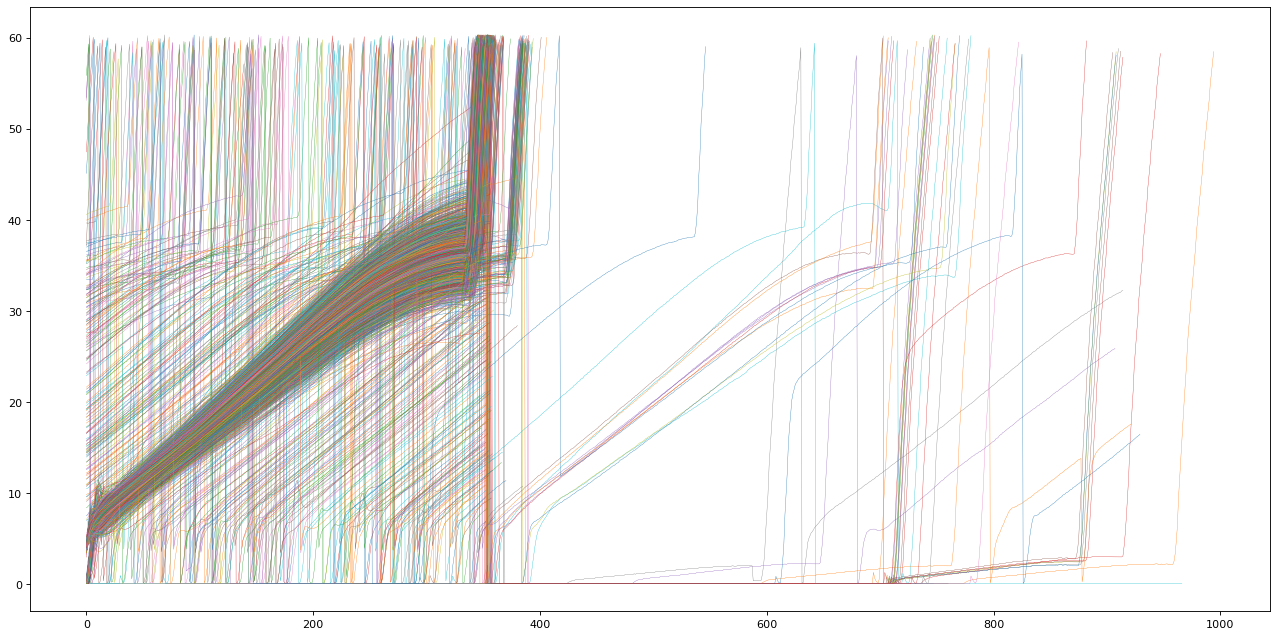

In [11]:
press_by_serial = pressate.groupby(['Seriale'])
# plot
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
for key, frame in press_by_serial:

    pressate_group = frame.groupby('Pressata')
    
    for pressata, var in pressate_group:
        if len(var['Valore']) < 1000 and pressata==5:
            seq = var['Valore']/var['Quota']

            ax.plot(list(range(0,len(seq))),seq, linewidth=0.3)

plt.show() 

In [12]:
pip install -U tslearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 793 kB 37.7 MB/s            
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Preparazione del dato per il clustering

In [5]:
list_of_list = list()
list_of_serial = list()
list_of_target = list()

press_by_serial = pressate.groupby(['Seriale'])

for key, frame in press_by_serial:

    pressate_group = frame.groupby('Pressata')
    
    for pressata, var in pressate_group:

        if len(var['Valore']) < 1000 and pressata==5:
            
            seq = list(var['Valore']/var['Quota'])
            list_of_list.append(seq)
            list_of_serial.append(key)
            list_of_target.append(esiti[esiti['Seriale']==key]['VIB602D2_800'])


import random 
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset

'''
n = 100

db_light = random.sample(list_of_list,n)

db_light = to_time_series_dataset(db_light)
scatter=TimeSeriesScalerMinMax(value_range=(0., 1.))
db_light_sc = scatter.fit_transform(db_light)  

'''
db_all = to_time_series_dataset(list_of_list)

scaler=TimeSeriesScalerMinMax(value_range=(0., 1.))
db_sc = scaler.fit_transform(db_all)  



# Clustering gerarchico

Calcolo una matrice delle distanze utilizzando il metodo DTW per il calcolo della distanza tra time sieries

In [12]:
from tslearn.metrics import dtw
from tqdm import tqdm
import pandas
import asyncio
import time


save_path='./'
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def distance(db_sc,i,j,distance_matrix):
    
        x = db_sc[i]
        y = db_sc[j]
        dist = dtw(x, y)
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

       




save_path='./'
# inizializzo la matrice delle distanze

n_series = len(db_sc)
distance_matrix = np.zeros(shape=(n_series, n_series))
dist=0
# Costruisco la matrice
for i in tqdm(range(n_series)):
    for j in range(n_series):
        if i < j:
        
            distance(db_sc,i,j,distance_matrix)

pd.DataFrame(distance_matrix).to_csv(save_path+'distance_matrix.csv')

100%|██████████| 2677/2677 [51:46<00:00,  1.16s/it]  


Uso il metodo ward per visualizzare il dendogramma e scegliere il numero di cluster ottimo 

In [ ]:
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distance_matrix,'ward')

/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


A valle di questa analisi emerge che il numero ottimo è 2 cluster

In [ ]:
print('fine')

In [50]:
np.savetxt("distance_matrix5.csv",distance_matrix , delimiter=",")

# Clustering con K-means

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
path='./model/'
km_dba = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5,
                            max_iter_barycenter=5,
                            random_state=0,n_jobs=-1,verbose=True)

y_pred = km_dba.fit_predict(db_sc)

km_dba.to_json(path+'km_dba5.json
print('fine')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2677 out of 2677 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    5.4s
[Parallel(n_job

0.725 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 5354 out of 5354 | elapsed:   13.2s finished


0.139 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 5354 out of 5354 | elapsed:   13.3s finished


0.103 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 5354 out of 5354 | elapsed:   13.3s finished


0.099 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 5354 out of 5354 | elapsed:   13.3s finished


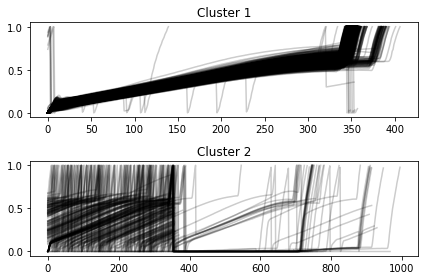

In [9]:

path='./fig/'
plt.figure()
for yi in range(2):
    plt.subplot(2, 1, 1 + yi)
    for xx in db_sc[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.savefig(path+'cluster-kmeans5.jpg')
plt.show()

# Clustering con KernelKMeans

In [ ]:
from tslearn.clustering import KernelKMeans
path='./model/'
gak_km = KernelKMeans(n_clusters=2,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=0,
                     n_jobs=-1)


y_pred1 = gak_km.fit_predict(db_sc)
gak_km.to_json(path+'gak_km5.json')
print('fine')

In [ ]:
plt.figure()
path='./fig/'
for yi in range(2):
    plt.subplot(2, 1, 1 + yi)
    for xx in db_sc[y_pred1 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.savefig(path+'cluster-KernelKMeans5.jpg')
plt.show()

# Analisi cluster 0

Calcolo una sequenza baricentrica del cluster 0

In [35]:
from tslearn.barycenters import dtw_barycenter_averaging

# dataset del cluster 0
c_0 = ts_sc[y_pred == 0]
# find baricentric time series
bar_series = dtw_barycenter_averaging(c_0,150)
plt.plot(bar_series)

Calcolo la distanza di ogni elemento del cluster dalla sequenza baricentrica e creo un vettore delle distanze

In [37]:
from tslearn.metrics import dtw

# Initialize distance matrix
n_series = 1295
distances = np.zeros(n_series)

# Build distance matrix

for j in range(n_series):
    y = c_0[j]
    
    dist = dtw(bar_series, y)
    distances[j] = dist

Ricerca degli outlier del cluster; prendo solo le sequenza che ricadono nel 10 percentile

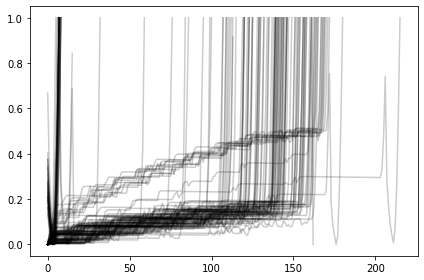

In [41]:
outliers = a[np.where(distances > np.percentile(distances, 90))]

plt.figure()

for xx in outliers:
    plt.plot(xx.ravel(), "k-", alpha=.2)


plt.tight_layout()
plt.show()